## Data Study

In this file we have the analysis using the final dataset builted in **Prepare Data - NEW** file.

1. **[Importing libraries](#Importinglibraries)**
2. **[Dataset Loading](#DatasetLoading)**
    1. [General Info](#GeneralInfo)
    2. [Exploration](#Exploration)
3. **[Nkill](#NKILL)**
    1. [Features](#Features)
    2. [P-Value](#Pvalue)
    3. [Scaler](#Scaler)
    4. [Linear Regression](#LR)
    5. [Generalize Linear Regression](#GLR)

<a id="Importinglibraries"></a>
### Importing libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy import asarray
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import *
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import isnan, when, count, col
from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StandardScaler
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix

Init Spark context

In [3]:
sc = pyspark.SparkContext(appName="Pi")

<a id="DatasetLoading"></a>
### Dataset Loading

Load the dataset

In [4]:
spark = SparkSession(sc)
ds = spark.read.csv("fin1shed_country_q.csv.gz", header=True, inferSchema=True)

<a id="GeneralInfo"></a>
**General Info**

**Rows:** 2045

**Columns:** 14

In [5]:
ds.show(5)

+---+-----+------------------+-------+-----+---------+------+-----------+-------------+--------+----------+-----+----------------------------+-------+
|_c0|iyear|       country_txt|country|nkill|ransom_No|nwound|property_Ok|individual_No|Firearms|Explosives|Melee|GDP per capita (current US$)|Nkill_q|
+---+-----+------------------+-------+-----+---------+------+-----------+-------------+--------+----------+-----+----------------------------+-------+
|  0| 1970|         Argentina|     11|  1.0|      1.0|   0.0|       0.75|          1.0|    0.75|       0.0|  0.0|            1317.48753519866|      1|
|  1| 1970|Dominican Republic|     58|  1.0|      1.0|   0.0|        0.0|          1.0|     0.0|       0.0|  0.0|            329.860647543011|      1|
|  2| 1970|           Germany|    362|  7.0|      1.0|   9.0|        1.0|          1.0|     0.0|       0.0|  0.0|          2750.7197423550397|      1|
|  3| 1970|           Germany|    499|  0.0|      1.0|   0.0|        1.0|          1.0|     0.

Check the dimensions

In [6]:
print((ds.count(), len(ds.columns)))

(2045, 14)


In [7]:
ds.columns

['_c0',
 'iyear',
 'country_txt',
 'country',
 'nkill',
 'ransom_No',
 'nwound',
 'property_Ok',
 'individual_No',
 'Firearms',
 'Explosives',
 'Melee',
 'GDP per capita (current US$)',
 'Nkill_q']

Let's remove the **Unnamed: 0** and **country_txt** columns. The first one because isn't usefull for the analisis and the second one because there is **country** that is the same only just converted in to number

In [8]:
ds1 = ds.drop(*['country_txt', '_c0','iyear','nkill','country'])
print((ds1.count(), len(ds1.columns)))

(2045, 9)


There's no NaN

In [9]:
ds1.select([count(when(isnan(c), c)).alias(c) for c in ds1.columns]).show()

+---------+------+-----------+-------------+--------+----------+-----+----------------------------+-------+
|ransom_No|nwound|property_Ok|individual_No|Firearms|Explosives|Melee|GDP per capita (current US$)|Nkill_q|
+---------+------+-----------+-------------+--------+----------+-----+----------------------------+-------+
|        0|     0|          0|            0|       0|         0|    0|                           0|      0|
+---------+------+-----------+-------------+--------+----------+-----+----------------------------+-------+



In [10]:
ds1.printSchema()

root
 |-- ransom_No: double (nullable = true)
 |-- nwound: double (nullable = true)
 |-- property_Ok: double (nullable = true)
 |-- individual_No: double (nullable = true)
 |-- Firearms: double (nullable = true)
 |-- Explosives: double (nullable = true)
 |-- Melee: double (nullable = true)
 |-- GDP per capita (current US$): double (nullable = true)
 |-- Nkill_q: integer (nullable = true)



<a id="Exploration"></a>
**Exploration**

Let's see the distribution of the datas

In [11]:
pdf = ds1.toPandas()
#sns.pairplot(pdf, vars=pdf.columns)

In [12]:
ds1.describe().show(vertical=True)

-RECORD 0-------------------------------------------
 summary                      | count               
 ransom_No                    | 2045                
 nwound                       | 2045                
 property_Ok                  | 2045                
 individual_No                | 2045                
 Firearms                     | 2045                
 Explosives                   | 2045                
 Melee                        | 2045                
 GDP per capita (current US$) | 2045                
 Nkill_q                      | 2045                
-RECORD 1-------------------------------------------
 summary                      | mean                
 ransom_No                    | 0.9519111477041735  
 nwound                       | 5.7030114437441055  
 property_Ok                  | 0.5528316463259231  
 individual_No                | 0.9874961260153154  
 Firearms                     | 0.3051913566853853  
 Explosives                   | 0.434038107219

Let's see the correlation of the datas.

it requires you to provide a column of type **Vector**. So we need to convert our columns into a vector column first using the **VectorAssembler** and then apply the correlation.

In [13]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=ds1.columns, outputCol=vector_col)
df_vector = assembler.transform(ds1).select(vector_col)
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

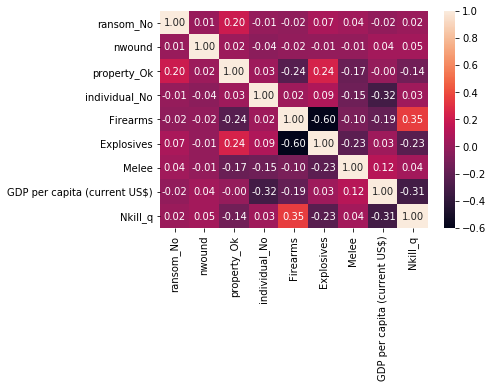

In [14]:
ax = sns.heatmap(corrmatrix, xticklabels=ds1.columns, yticklabels=ds1.columns, annot=True, fmt=".2f")

In [15]:
vif = pd.DataFrame()
pdf = pdf.drop(columns="Nkill_q")
vif["VIF Factor"] = [variance_inflation_factor(pdf.values, i) for i in range(pdf.shape[1])]
vif["features"] = pdf.columns
vif

,VIF Factor,features
0,34.557099,ransom_No
1,1.011461,nwound
2,3.624178,property_Ok
3,33.185714,individual_No
4,3.191234,Firearms
5,4.014192,Explosives
6,1.313466,Melee
7,1.399707,GDP per capita (current US$)


In [16]:
#vif = pd.DataFrame()
#pdf = pdf.drop(columns={"iyear", "region"})
#vif["VIF Factor"] = [variance_inflation_factor(pdf.values, i) for i in range(pdf.shape[1])]
#vif["features"] = pdf.columns
#vif

<a id="NKILL"></a>
## NKILL

In this section we use NKILL as response variable.

<a id="Features"></a>
**Features** 

we procede to build the feature column combining all the columns except the **nkill** column, that will be our response. To achieve this pourpose we use **VectorAssembler** and the result is called **features**

In [17]:
f_columns = ds1.select([c for c in ds1.columns if c not in {'Nkill_q'}]).columns
len(f_columns)

8

In [18]:
assembler = VectorAssembler(inputCols=f_columns,outputCol="features")

In [19]:
feature = assembler.transform(ds1) 
feature.show(2, False, vertical= True)

-RECORD 0------------------------------------------------------------------------
 ransom_No                    | 1.0                                              
 nwound                       | 0.0                                              
 property_Ok                  | 0.75                                             
 individual_No                | 1.0                                              
 Firearms                     | 0.75                                             
 Explosives                   | 0.0                                              
 Melee                        | 0.0                                              
 GDP per capita (current US$) | 1317.48753519866                                 
 Nkill_q                      | 1                                                
 features                     | [1.0,0.0,0.75,1.0,0.75,0.0,0.0,1317.48753519866] 
-RECORD 1------------------------------------------------------------------------
 ransom_No      

In [20]:
feature.select("features").show(10, False)

+-----------------------------------------------------------------------------------------------------------+
|features                                                                                                   |
+-----------------------------------------------------------------------------------------------------------+
|[1.0,0.0,0.75,1.0,0.75,0.0,0.0,1317.48753519866]                                                           |
|(8,[0,3,7],[1.0,1.0,329.860647543011])                                                                     |
|[1.0,9.0,1.0,1.0,0.0,0.0,0.0,2750.7197423550397]                                                           |
|[1.0,0.0,1.0,1.0,0.0,1.0,0.0,2750.7197423550397]                                                           |
|(8,[0,3,4,7],[1.0,1.0,1.0,2347.54431773747])                                                               |
|[1.0,0.2954545454545455,0.6818181818181818,1.0,0.18181818181818185,0.6363636363636364,0.0,5246.88371730098]|
|(8,[0,3,7

<a id="Pvalue"></a>
**P-Value** 

In [21]:
chisq = ChiSquareTest.test(feature,"features","Nkill_q").head()
pvalue = pd.Series(chisq.pValues , index=f_columns)
print("P-Value:\n",pvalue )

P-Value:
 ransom_No                       3.885781e-15
nwound                          0.000000e+00
property_Ok                     0.000000e+00
individual_No                   3.645279e-01
Firearms                        0.000000e+00
Explosives                      0.000000e+00
Melee                           0.000000e+00
GDP per capita (current US$)    5.300967e-02
dtype: float64


In [53]:
f_columns = ds1.select([c for c in ds1.columns if c not in {'Nkill_q', "iyear", "country"}]).columns
len(f_columns)

8

In [54]:
assembler = VectorAssembler(inputCols=f_columns,outputCol="features")

In [55]:
feature = assembler.transform(ds1) 
feature.show(2, False, vertical= True)

-RECORD 0------------------------------------------------------------------------
 ransom_No                    | 1.0                                              
 nwound                       | 0.0                                              
 property_Ok                  | 0.75                                             
 individual_No                | 1.0                                              
 Firearms                     | 0.75                                             
 Explosives                   | 0.0                                              
 Melee                        | 0.0                                              
 GDP per capita (current US$) | 1317.48753519866                                 
 Nkill_q                      | 1                                                
 features                     | [1.0,0.0,0.75,1.0,0.75,0.0,0.0,1317.48753519866] 
-RECORD 1------------------------------------------------------------------------
 ransom_No      

<a id="Scaler"></a>
**Scaler** 

In [56]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=True)
scalerModel = scaler.fit(feature)
scaledData = scalerModel.transform(feature)
scaledData.show(2, vertical= True)

-RECORD 0--------------------------------------------
 ransom_No                    | 1.0                  
 nwound                       | 0.0                  
 property_Ok                  | 0.75                 
 individual_No                | 1.0                  
 Firearms                     | 0.75                 
 Explosives                   | 0.0                  
 Melee                        | 0.0                  
 GDP per capita (current US$) | 1317.48753519866     
 Nkill_q                      | 1                    
 features                     | [1.0,0.0,0.75,1.0... 
 scaledFeatures               | [0.32340173353411... 
-RECORD 1--------------------------------------------
 ransom_No                    | 1.0                  
 nwound                       | 0.0                  
 property_Ok                  | 0.0                  
 individual_No                | 1.0                  
 Firearms                     | 0.0                  
 Explosives                 

<a id="VIF1"></a>
**Variance Inflation Factor** 

In [26]:
#vif = pd.DataFrame()
#vif["VIF Factor"] = [variance_inflation_factor(ds1_scaled.values, i) for i in range(ds1_scaled.shape[1])]
#vif["features"] = ds1_scaled.columns
#vif

<a id="LR"></a>
**Linear Regression** 

Let's procede to build a model and evaluate them. The first step it's to build a model. We use a Linear regression and to evaluate the performance of the esmtimator we relied on the study of residuals, in particular way we use the R^2 indicator.

In [57]:
df_ready = scaledData.select([c for c in scaledData.columns if c in ["scaledFeatures", "Nkill_q"]])
df_ready = scaledData.selectExpr("scaledFeatures as features", "Nkill_q as label")

In [58]:
train, test = df_ready.randomSplit([0.8, 0.2], seed=12345)

In [59]:
lr = LogisticRegression()
grid = ParamGridBuilder().addGrid(lr.maxIter, [50]).addGrid(lr.elasticNetParam, [0.2]).addGrid(lr.regParam, [1e-4]).build()
evaluator = RegressionEvaluator(metricName="r2")

In [60]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator, numFolds=10, seed=33, parallelism=2)

In [61]:
cvModel = cv.fit(train)

In [62]:
bestModel = cvModel.bestModel.summary

In [63]:
print("MIGLIOR MODELLO: ")
model = cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)]
for key, value in model.items() :
    print (key, value)
print(bestModel.falsePositiveRateByLabel)
print(bestModel.accuracy)
print(bestModel.truePositiveRateByLabel)
xx = cvModel.transform(test)
xx.show()
#print("R^2: ", bestModel.r2adj)
#print("ITERATION: ", bestModel.totalIterations)
#print("MIGLIOR MODELLO TEST R^2: ", evaluator.evaluate(cvModel.transform(test)))

MIGLIOR MODELLO: 
LogisticRegression_28f3c33ec21a__maxIter 50
LogisticRegression_28f3c33ec21a__elasticNetParam 0.2
LogisticRegression_28f3c33ec21a__regParam 0.0001
[0.18289353958143767, 0.46012931034482757, 0.10620220900594732]
0.5299625468164794
[0.7137176938369781, 0.5890207715133531, 0.2188235294117647]
+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[-6.4016856431544...|    0|[0.68978202294591...|[0.56203415605546...|       0.0|
|[-6.4016856431544...|    0|[0.77177888182698...|[0.59687499826423...|       0.0|
|[-6.4016856431544...|    0|[0.99751213121663...|[0.68242478761663...|       0.0|
|[-6.4016856431544...|    1|[-1.0395622628970...|[0.09297147589626...|       2.0|
|[-6.4016856431544...|    1|[-0.9556744653193...|[0.10555726266409...|       2.0|
|[-6.4016856431544...|    0|[-0.5924

In [64]:
bestModel.fMeasureByLabel()

[0.6754468485418627, 0.5300400534045394, 0.2892690513219284]

In [65]:
pd.Series(cvModel.bestModel.coefficientMatrix , index=f_columns)

ransom_No                       DenseMatrix([[-0.07484303, -0.42412827,  0.107...
nwound                          DenseMatrix([[-0.07484303, -0.42412827,  0.107...
property_Ok                     DenseMatrix([[-0.07484303, -0.42412827,  0.107...
individual_No                   DenseMatrix([[-0.07484303, -0.42412827,  0.107...
Firearms                        DenseMatrix([[-0.07484303, -0.42412827,  0.107...
Explosives                      DenseMatrix([[-0.07484303, -0.42412827,  0.107...
Melee                           DenseMatrix([[-0.07484303, -0.42412827,  0.107...
GDP per capita (current US$)    DenseMatrix([[-0.07484303, -0.42412827,  0.107...
dtype: object

In [66]:
coef = cvModel.bestModel.coefficientMatrix.toArray()

In [67]:
pd.DataFrame(data=coef, columns=f_columns, index=['class_0', 'class_1', 'class_2'])

,ransom_No,nwound,property_Ok,individual_No,Firearms,Explosives,Melee,GDP per capita (current US$)
class_0,-0.074843,-0.424128,0.107611,0.061308,-0.657313,-0.064091,-0.167827,0.561770
class_1,0.098780,0.053284,-0.080227,-0.069753,0.301758,0.128494,0.061420,0.134920
class_2,-0.009438,0.235780,-0.031273,-0.045266,0.328225,-0.188213,0.086063,-0.759065


<a id="GLR"></a>
**MLPC** 

In [77]:
# input controlla riga sopra
# output 3 classi
layers = [8, 7, 7, 3]

trainer = MultilayerPerceptronClassifier(maxIter=200, layers=layers, blockSize=128, seed=1234)

# train the model
model = trainer.fit(train)

# compute accuracy on the test set
result = model.transform(test)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

Test set accuracy = 0.6975169300225733


In [69]:
prediction_test = result.select("prediction").toPandas()
label_test = result.select("label").toPandas()

In [70]:
label_test.label.value_counts()

1    176
0    138
2    129
Name: label, dtype: int64

In [71]:
confusion_matrix(label_test, prediction_test)

array([[ 93,  44,   1],
       [ 37, 116,  23],
       [  2,  27, 100]])

Always stop the context.

In [41]:
#sc.stop()